In [15]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from sklearn.metrics import roc_curve

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.read_data
%aimport models.train_model
%aimport features.build_features
%aimport visualization.visualize
from data.read_data import read_data, get_stopwords
from models.train_model import split_train, score_function, get_fasttext, model_ridge, model_xgb
from features.build_features import get_vec, to_categorical, replace_na, to_tfidf, stack_sparse
from visualization.visualize import plot_roc, plot_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = read_data(test=False)
y = train['Target']
stopwords = get_stopwords()

In [3]:
train.head()

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


# Feature engineering

In [4]:
train = replace_na(train, ['review_content', 'review_title'])

In [5]:
X_dummies = to_categorical(train, 'review_stars')

In [6]:
X_content = to_tfidf(train, 'review_content', stopwords)
X_title = to_tfidf(train, 'review_title', stopwords)

In [7]:
X_length = to_sparse_int(train, 'review_content')

In [9]:
sparse_merge = stack_sparse([X_dummies, X_content, X_title, X_length])

In [10]:
X_train, X_test, y_train, y_test = split_train(sparse_merge, y, 0.2)

# LightGBM

In [18]:
import lightgbm as lgb

In [19]:
d_train = lgb.Dataset(X_train, label=y_train)#, max_bin=8192)
d_test = lgb.Dataset(X_test, label=y_test)#, max_bin=8192)

In [20]:
params = {
        'learning_rate': 0.75,
        'application': 'binary',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': 1,
        'metric': 'auc',
    }

model = lgb.train(params, train_set=d_train, num_boost_round=3335,  \
verbose_eval=100) 

In [21]:
preds = model.predict(X_test)

In [22]:
score_function(y_test, preds)

0.68407669019813144

# Ridge

In [11]:
model_rdg = model_ridge(X_train, y_train)
preds = model_rdg.predict(X=X_test)
score_function(y_test, preds)

0.66989583616017589

In [33]:
fpr, tpr, _ = roc_curve(y_test, preds)

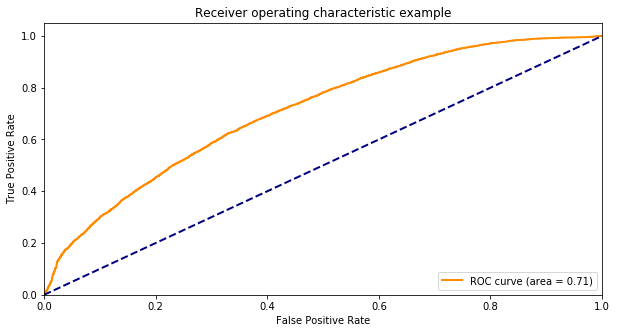

In [34]:
plot_roc(fpr, tpr)

# Xgboost

In [12]:
model_xgboost = model_xgb(X_train, y_train)
preds = model_xgboost.predict_proba(X_test)
preds1 = preds[:,1]
score_function(y_test, preds1)

0.71035225050866624

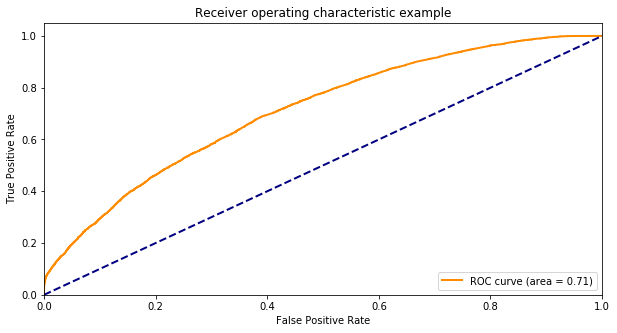

In [16]:
fpr, tpr, _ = roc_curve(y_test, preds1)
plot_roc(fpr, tpr)